In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pickle
import joblib
import time

Labels

In [3]:
labels_df = pd.read_csv("../linkedin_salary_targets.csv")

In [156]:
# for line in [f'{f[:-4]}_df = pd.read_csv("linkedin/{f}")' for f in os.listdir("linkedin") if f.endswith("csv")]:
#     print(line)

# for line in [f'"{f[:-4]}": {f[:-4]}_df' for f in os.listdir("linkedin") if f.endswith("csv")]:
#     print(line)

Features

In [153]:
bigram_df = pd.read_csv("../features/linkedin/bigram.csv")
t5_title_embedding_df = pd.read_csv("../features/linkedin/t5_title_embedding.csv")
paraphrase_title_embedding_df = pd.read_csv("../features/linkedin/paraphrase_title_embedding.csv")
t5_total_embedding_df = pd.read_csv("linkedin/t5_total_embedding.csv")
smoothed_unigram_df = pd.read_csv("linkedin/smoothed_unigram.csv")
paraphrase_total_embedding_df = pd.read_csv("linkedin/paraphrase_total_embedding.csv")
unigram_df = pd.read_csv("linkedin/unigram.csv")
tfidf_df = pd.read_csv("linkedin/tfidf.csv")

In [114]:
models = {
    "bigram": bigram_df,
    "t5_title_embedding": t5_title_embedding_df,
    "paraphrase_title_embedding": paraphrase_title_embedding_df,
    "t5_total_embedding": t5_total_embedding_df,
    "smoothed_unigram": smoothed_unigram_df,
    "paraphrase_total_embedding": paraphrase_total_embedding_df,
    "unigram": unigram_df,
    "tfidf": tfidf_df
}

In [163]:
def train_and_score_gbt(X, y, model_name, dataset_name="linkedin"):
    # 1. Split Data
    X_train, X_test, y_train, y_test = train_test_split(X,y)

    # 2. Train GBT Model
    clf = GradientBoostingRegressor(n_estimators=100, learning_rate=1.0,
        max_depth=5, random_state=0)
    clf.fit(X_train,y_train)

    # 3. Get Predictions and Residuals
    y_pred = clf.predict(X_test)
    residuals = y_test - y_pred

    # 4. Score
    scores = {
        'model_name': model_name,
        'r2': r2_score(y_pred, y_test),
        'mea': mean_absolute_error(y_pred, y_test),
        'rmse': root_mean_squared_error(y_pred, y_test)
    }

    # 5. Plot
    plt.scatter(y_pred, residuals)
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title(f'Residual Plot: {model_name}')
    plt.axhline(y=0, color='r', linestyle='--')
    os.mkdir(f"results/dataset_name/{model_name}")
    plt.savefig(f"results/dataset_name/{model_name}/residuals.jpg")
    plt.clf()
    
    # 6. Save Model and Scores
    joblib.dump(clf, f"results/dataset_name/{model_name}/model_object.pkl")
    joblib.dump(clf, f"results/dataset_name/{model_name}/model_scores.pkl")

    # return scores

In [166]:
scores_df = pd.DataFrame(columns=['model_name','r2','mea','rmse'])

for (model_name, features_df) in models.items():
    t0 = time.time()

    scores = train_and_score_gbt(
        X=features_df.to_numpy(), 
        y=labels_df.max_salary.to_numpy(),
        model_name=model_name
    )
    # scores_df = pd.concat([scores_df, pd.DataFrame([scores])], ignore_index=True)
    t1 = time.time()
    total = t1-t0
    print(f"Finished {model_name} in {total} seconds.")
    # print(scores_df.head())

Finished bigram in 0.5376451015472412 seconds.
Finished t5_title_embedding in 0.9034378528594971 seconds.
Finished paraphrase_title_embedding in 0.47110819816589355 seconds.
Finished t5_total_embedding in 0.831049919128418 seconds.
Finished smoothed_unigram in 0.4692850112915039 seconds.
Finished paraphrase_total_embedding in 0.44088006019592285 seconds.
Finished unigram in 0.39644408226013184 seconds.


<Figure size 640x480 with 0 Axes>

In [6]:
scores_df = pd.read_csv("results/linkedin/scores.csv").drop(columns=["Unnamed: 0"])

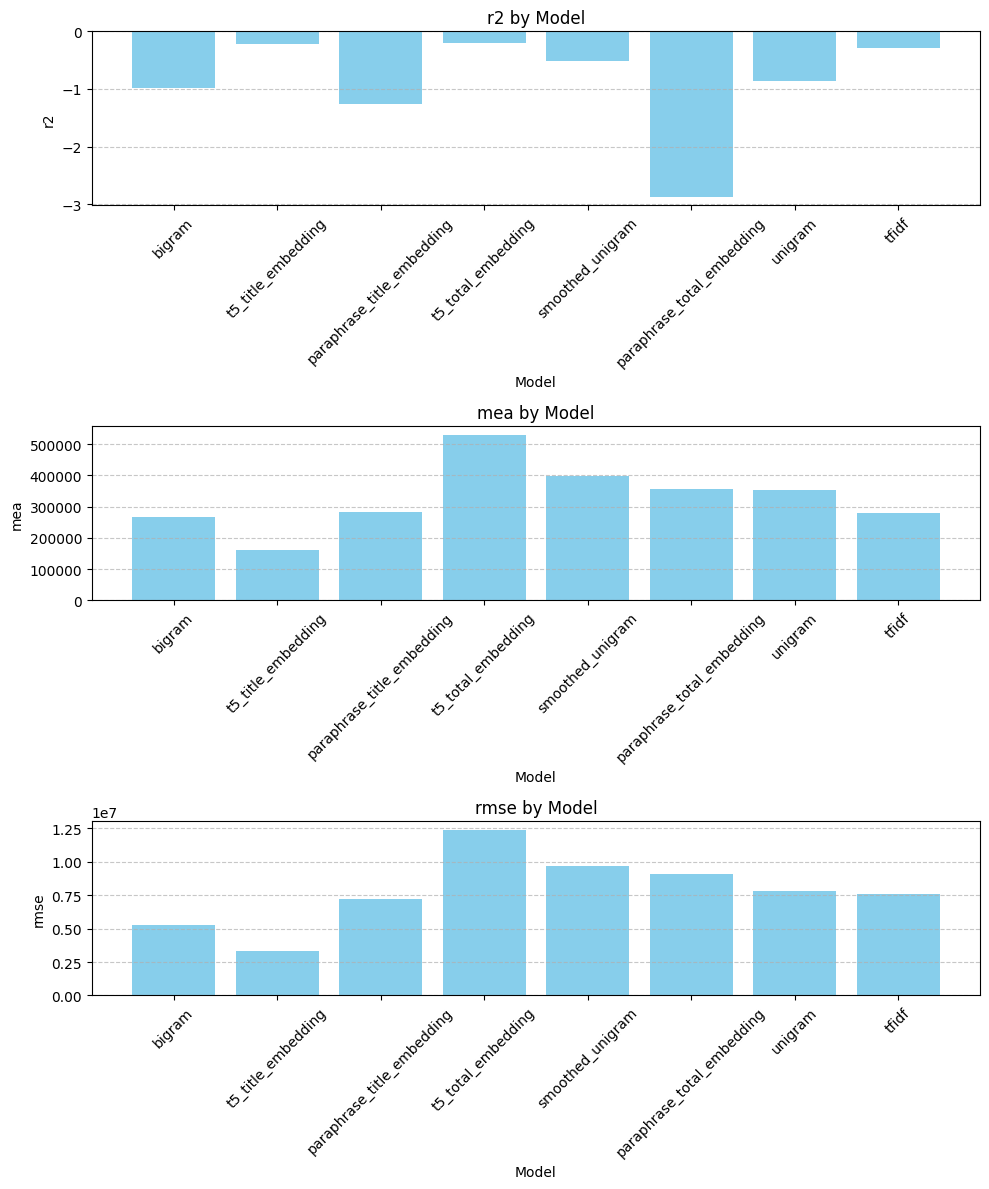

In [12]:
models = scores_df["model_name"]
scores = scores_df.iloc[:, 1:]  # All score columns
score_columns = scores.columns

# Bar width and positions
bar_width = 0.2
x = np.arange(len(models))  # Position of models on x-axis

plt.figure(figsize=(10, 12))

for i, (score_name, score_values) in enumerate(scores.items(), start=1):
    plt.subplot(3, 1, i)  # Create a subplot for each score
    plt.bar(models, score_values, color="skyblue")
    plt.title(f"{score_name} by Model")
    plt.xlabel("Model")
    plt.ylabel(score_name)
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.xticks(rotation=45)
# Adjust layout
plt.tight_layout()
plt.show()